In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp

In [14]:
def weinbergSelfishReward(a, g):
    num = 5*a**2 - 12*a**3 + 9*a**4 - 2*a**5 + g * (a - 4*a**2 + 6*a**3 - 5*a**4 + 2*a**5)
    den = 2*a**3 - 4*a**2 + 1
    return num / den

def eyalSelfishReward(a, g):
    num = a * (1-a)**2 * (4*a + g*(1-2*a)) - a**3
    den = 1 - a*(1+(2-a)*a)
    return num / den

def oursSelfishReward(a, g):
    num = a * (2*a**3*g - 2*a**3 - 5*a**2*g + 8*a**2 + 4*a*g - 4*a - g)
    den = a**3 + a**2 + a - 1
    return num / den

In [24]:
alphas = np.arange(0.001, 0.50, 0.001)
wRes, eRes, oRes = [], [], []
for g in [0, 0.5, 1]:
    wRes.append(weinbergSelfishReward(alphas, g))
    eRes.append(eyalSelfishReward(alphas, g))
    oRes.append(oursSelfishReward(alphas, g))
wRes = np.array(wRes)
eRes = np.array(eRes)
oRes = np.array(oRes)

wRes.shape, eRes.shape, oRes.shape

((3, 499), (3, 499), (3, 499))

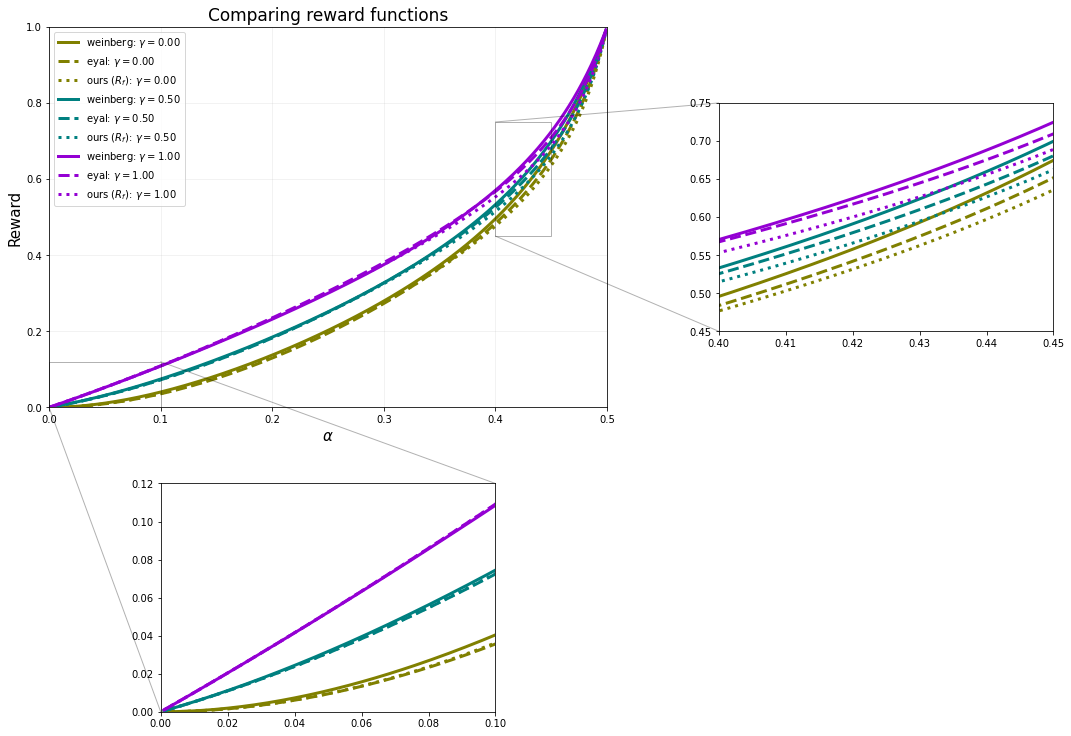

In [31]:
f, ax = plt.subplots(figsize=(10,7))

axins0 = ax.inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0., 0.1), ylim=(0., .12))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.4, 0.45), ylim=(0.45, 0.75))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)


colors = ['olive', 'teal', 'darkviolet']
for i, g in enumerate([0, 0.5, 1]):
    for a in [ax, axins0, axins1]:
        a.plot(alphas, wRes[i], linewidth=3, color=colors[i], label=r'weinberg: $\gamma={:0.2f}$'.format(g))
        a.plot(alphas, eRes[i], linewidth=3, color=colors[i], label=r'eyal: $\gamma={:0.2f}$'.format(g),
                linestyle='--')
        a.plot(alphas, oRes[i], linewidth=3, color=colors[i], label=r'ours ($R_f$): $\gamma={:0.2f}$'.format(g),
                linestyle='dotted')
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Reward', size=15)
ax.set_title(r'Comparing reward functions', size=17)

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)
ax.grid(alpha=0.2)
ax.legend(loc=2)
plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [32]:
# R_f general
a, b, g = sp.symbols('alpha beta gamma')

A_expr = a * (sp.exp(-b) / (a*(1-sp.exp(-b))) + 2 - a + ((2-a)/(1-a)) + ((((1-a)**2)*g)/a) + (a**2/((1-2*a)*(1-a))))
H_expr = (1-a) / (a*(1-sp.exp(-b))) + ((1-a)**2)*(2-g) + a*(1-a)

R_f = A_expr / (A_expr + H_expr)

simplified_Rf = sp.simplify(R_f)
simplified_Rf

alpha*(2*alpha**3*gamma*exp(beta) - 2*alpha**3*gamma - 2*alpha**3*exp(beta) + 2*alpha**3 - 5*alpha**2*gamma*exp(beta) + 5*alpha**2*gamma + 8*alpha**2*exp(beta) - 8*alpha**2 + 4*alpha*gamma*exp(beta) - 4*alpha*gamma - 4*alpha*exp(beta) + 6*alpha - gamma*exp(beta) + gamma - 1)/(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta))

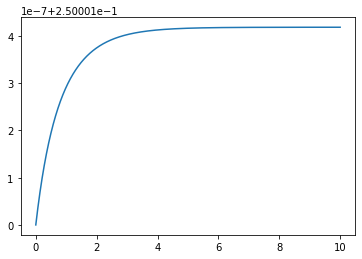

In [62]:
# sanity check that this is monotone increasing in beta (when SM is profitable)
# conversly, it is monotone decreasing in beta when SM is not-profitable (best beta = 0 \implies honest)
func = sp.lambdify((b), simplified_Rf.evalf(subs={a : 0.250001, g : 0.5}))
betas = np.arange(0, 10, 0.001)
plt.plot(betas, func(betas))

In [33]:
lim = sp.limit(R_f, b, sp.oo)
lim

(2*alpha**4*gamma - 2*alpha**4 - 5*alpha**3*gamma + 8*alpha**3 + 4*alpha**2*gamma - 4*alpha**2 - alpha*gamma)/(alpha**3 + alpha**2 + alpha - 1)